In [254]:
#--------RGB histogram match---------------------#

import PIL
from PIL import Image
import imagehash
import os
import cv2
import time
from pprint import pprint
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import random

#to reload module: uncomment use the following 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
# reading query image
# q_path = random.sample(trainhistpath, 1)[0]
q_path = './imagesbooks/ukbench06049.jpg'
print (q_path)
q_paths = list(paths.list_images('./imagesbooks'))

./imagesbooks/ukbench06049.jpg


In [256]:
# visualizing the histogram
def showHistograms (q_paths,texts=['']*len(q_paths)): # list of paths 
    l=0
    for q_path in q_paths:
        img = cv2.imread(q_path)
        color = ('b','g','r')
        plt.figure(figsize=(4,4))
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            histr = cv2.normalize(histr, None)
            plt.plot(histr,color = col, linewidth=2.0)
            plt.xlim([0,256])
        plt.title(texts[l])
        plt.show()
        l+=1

def showHistogramTable (q_paths, texts=['']*len(q_paths), sfactor=5, columns = 5):
    # sfactor = 5, 
    # columns = 5
    rows = len(q_paths)//columns + ( 1 if (len(q_paths)%columns > 0 ) else 0 )
    l = 0
    fig=plt.figure(figsize=(sfactor*columns, sfactor*rows))
    ax = []
    for i in range(1, columns*rows +1):
        if l<len(q_paths) :             
#             plt.figure(figsize=(4,4))
            ax.append(fig.add_subplot(rows, columns, i))

            img = cv2.imread(q_paths[l])
            color = ('b','g','r')
            
            for i,col in enumerate(color):
                histr = cv2.calcHist([img],[i],None,[256],[0,256])
                histr = cv2.normalize(histr, None)
                plt.title(texts[l])
                # plt.plot(histr,color = col)
                ax[-1].plot(histr,color = col, linewidth=2.0)
                # ax[-1].xlim([0,256])    
            # ax[-1].set_title('score= %2.2f'%texts[l])            
            # ax[-1].set_title(texts[l])
            # plt.imshow(img)
            l+= 1

In [269]:
# visualizing the histogram
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    
    print("Actual matches (knn):", len(matches))
    return matches

def showKeypoints (q_paths, sift_features_limit, gray=False): # list of paths 
    for q_path in q_paths:
        img = cv2.imread(q_path)        
        if img is None:
            continue
        m_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if gray: 
            g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else: 
            g_img = m_img
        
        sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
        # kp is the keypoints
        # desc is the SIFT descriptors, they're 128-dimensional vectors
        # that we can use for our final features
        kp, desc = sift.detectAndCompute(m_img, None)
        
        plt.figure(figsize=(10,8))
        
        # plt.imshow(cv2.drawKeypoints(m_img, kp, None, color=(0,255,0)))  
        plt.imshow(cv2.drawKeypoints(g_img, kp, None, color=(0,255,0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))          
        plt.title('kp=%3d'%sift_features_limit)
        plt.show()
        
def showMatchKeypoints(pathimg1, pathimg2, sift_features_limit, matchType = 'knn'):
    pimg1 = cv2.imread(pathimg1)
    pimg2 = cv2.imread(pathimg2)
    gimg1 = cv2.cvtColor(pimg1, cv2.COLOR_BGR2GRAY)
    gimg2 = cv2.cvtColor(pimg2, cv2.COLOR_BGR2GRAY)
    img1 = cv2.cvtColor(pimg1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(pimg2, cv2.COLOR_BGR2RGB)

    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    kpsA, featuresA = sift.detectAndCompute(img1, None)
    kpsB, featuresB = sift.detectAndCompute(img2, None)
    
    plt.figure(figsize=(20,8))
    
    if matchType == 'bf': 
        matches = matchKeyPointsBF(featuresA, featuresB, method='sift')
        img3 = cv2.drawMatches(pimg1, kpsA, pimg2, kpsB, matches[:100], None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    
    elif matchType == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method='sift')
        img3 = cv2.drawMatches(gimg1, kpsA, gimg2, kpsB, np.random.choice(matches,100), None,flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)


    plt.imshow(img3)
    plt.show()
    
    
    
def showImages (q_paths): # list of paths 
    for item in q_paths : 
        plt.figure(figsize = (4,4))
        img = plt.imread (item)
        plt.imshow (img)
        plt.show()
        
def showImagesTable (q_paths, texts=['']*len(q_paths), sfactor = 3, columns = 5): 
    # sfactor = 3
    columns = 5
    rows = len(q_paths)//columns + ( 1 if (len(q_paths)%columns > 0 ) else 0 )
    l = 0
    fig=plt.figure(figsize=(sfactor*columns, sfactor*rows))
    ax = []
    
    # start plotting 
    for i in range(1, columns*rows +1):
        if l<len(q_paths) : 
            img = plt.imread(q_paths[l])
            ax.append(fig.add_subplot(rows, columns, i))
#             ax[-1].set_title('score= %2.2f'%texts[l])            
            ax[-1].set_title(texts[l])
            plt.imshow(img)
        l +=1
    plt.show()

# -----------------------
# notes 
# columns = len(d)
# rows = 1
# define fig as function of row, col
# fig=plt.figure(figsize=(rows*1, columns*1))
# fig=plt.figure(figsize=(10,10))
# fig=plt.figure(figsize=(20*columns, 20))

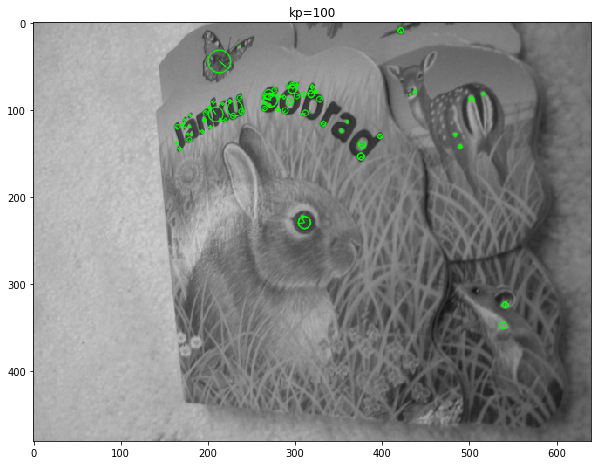

In [270]:
showKeypoints ([q_paths[157]], 100, gray=True)

Raw matches (knn): 70
Actual matches (knn): 27


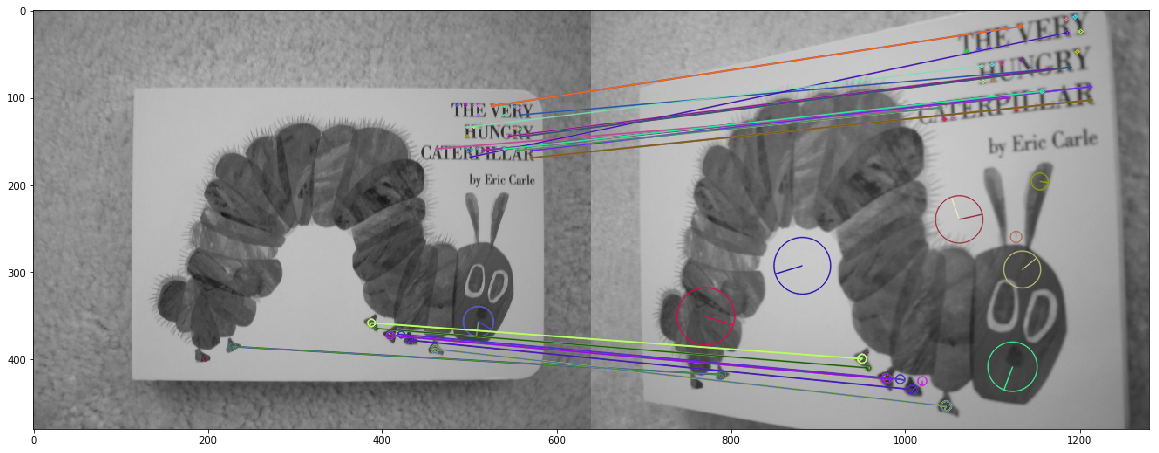

Raw matches (knn): 200
Actual matches (knn): 81


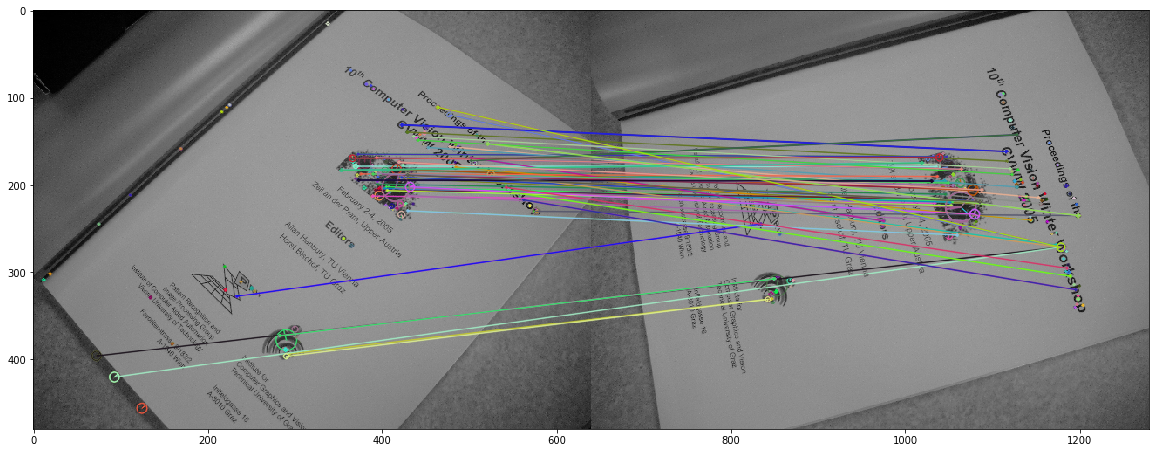

In [278]:
showMatchKeypoints (q_paths[35], q_paths[33], 70, matchType='knn')
showMatchKeypoints (q_paths[299], q_paths[298], 200, matchType='knn')

In [106]:
q_paths = ['./imagesbooks/ukbench06049.jpg', './imagesbooks/ukbench06050.jpg', './imagesbooks/ukbench06051.jpg', './imagesbooks/ukbench06048.jpg', './imagesbooks/ukbench05598.jpg', './imagesbooks/ukbench05964.jpg', './imagesbooks/ukbench05599.jpg', './imagesbooks/ukbench05603.jpg', './imagesbooks/ukbench05600.jpg', './imagesbooks/ukbench05965.jpg', './imagesbooks/ukbench05966.jpg', './imagesbooks/ukbench05602.jpg', './imagesbooks/ukbench05967.jpg']

In [272]:
q_paths = sorted(list(paths.list_images('./imagesbooks')))
q_list = q_paths
# showImages(q_list)
# showImagesTable (q_list)
# showImagesTable (q_list)
# showHistogramTable(q_list, q_list)

## Hist Equalization 

Raw matches (knn): 70
Actual matches (knn): 18


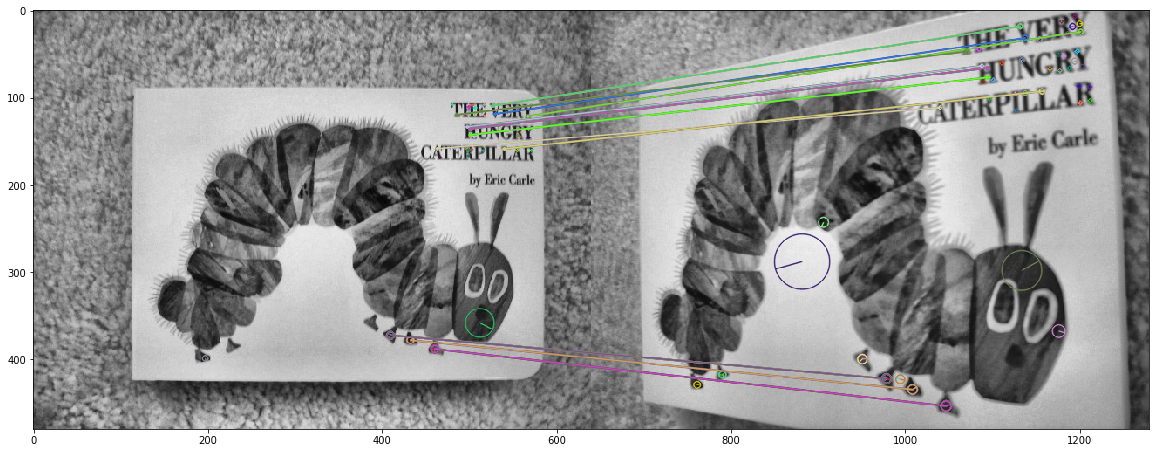

In [289]:
# q_paths = sorted(list(paths.list_images('./images/imagesbooks_EQ2/')))
q_list = q_paths
# showImages(q_list)
# showImagesTable (q_list)

# show equalized historgams for the same images 
# dq_list = q_list
# dq_list = [w.replace('imagesbooks', 'images/imagesbooks_EQ2/') for w in q_list]
dq_list = [w.replace('imagesbooks', 'images/imagesbooks_DENOISE2//') for w in q_list]
dq_list = [w.replace('imagesbooks', 'images/imagesbooks_EQ2/') for w in q_list]

# showHistogramTable(dq_list, dq_list)
showMatchKeypoints (dq_list[35], dq_list[33], 70, matchType='knn')

## Contrast 2.0 

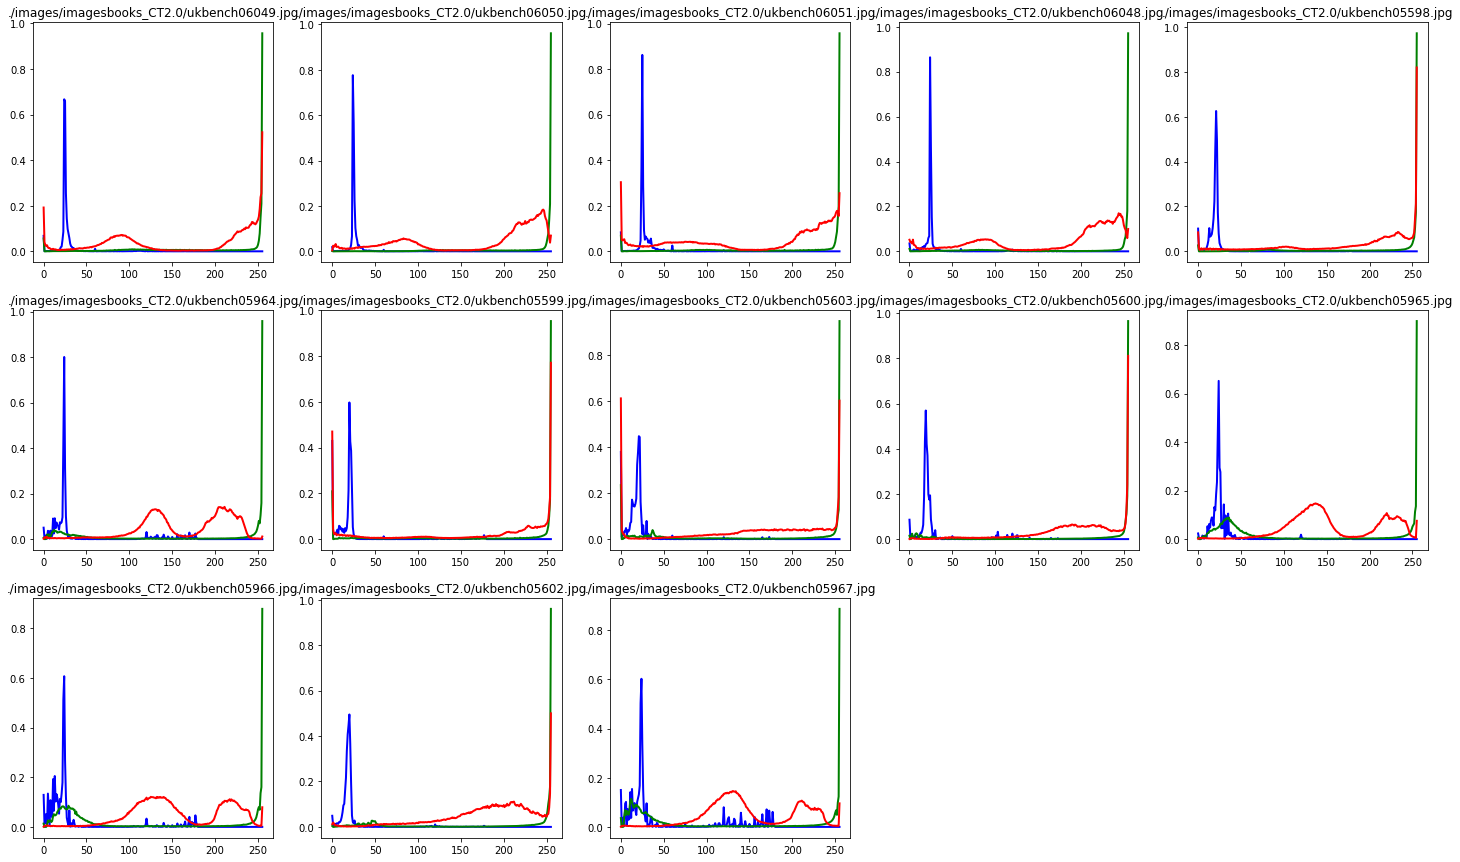

In [440]:
# show equalized historgams for the same images 
dq_list = [w.replace('imagesbooks', 'images/imagesbooks_CT2.0') for w in q_list]
showHistogramTable(dq_list, dq_list)

# Generate SIFT features 

In [236]:
#### check Gaussian nature of scores and success positions
import ImageSearch_Algo_HSV
import ImageSearch_Algo_RGB
import ImageSearch_Algo_SIFT
import Accuracy as accuracy
from kneed import KneeLocator
import random 
import matplotlib.pyplot as plt

In [237]:
def getHSVDistScores (q_path):
    # q_path = './imagesbooks/ukbench06049.jpg'
    q_img = cv2.imread(q_path)
    query_paths = [q_path]
    # histogram of query images 
    hist_query = []
    for path in query_paths:
        image = cv2.imread(path)

        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        # extract a RGB color histogram from the image,
        # using 8 bins per channel, normalize, and update the index
        hist = cv2.calcHist([image], [0, 1, 2], None, [8, 12, 8],[0, 180, 0, 256, 0, 256])
        # hist = cv2.normalize(hist, None)
        hist_query.append((path,hist))

    # Histmatch = pd.DataFrame(colums= ['file','matches'])
    hist_matches = []
    for i in range(len(hist_query)):
        matches = []

        for index, row in Trainhist.iterrows():

            cmp = cv2.compareHist(hist_query[i][1], row['imagehist'], cv2.HISTCMP_BHATTACHARYYA)
            # cmp = cv2.compareHist(hist_query[i][1], row['imagehist'], cv2.HISTCMP_CHISQR)


            #if cmp > 0.3:
            matches.append((cmp, row['file']))

        matches.sort(key=lambda x : x[0] , reverse = False)
        hist_matches.append((hist_query[i][0],matches))
    return hist_matches

    # print (hist_matches)

In [238]:
# q_path = './imagesbooks/ukbench06048.jpg'
q_path = './imagesbooks/ukbench10167.jpg' # tough one 

q ,  myscore = getHSVDistScores(q_path)[0]
res = list(zip(*myscore)) # unzip to list 

X = np.asarray(res[0])

NameError: name 'Trainhist' is not defined

In [20]:
X.shape

NameError: name 'X' is not defined

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
sns.distplot(X, hist=False, rug=True, color='r');

NameError: name 'X' is not defined

In [23]:
score = []
successScore = []
# score, file = item
for item in myscore:
    x, y = item
    score.append(x)
# print(score)
a, d, ind, cnt = accuracy.accuracy_matches(q_path, myscore, 20)
successPositions =ind
for i in ind: 
    successScore.append(score[i])
print ('Success positions',ind)
# PLOT 
# sns.set(style="whitegrid")
sns.distplot(X, hist=False, rug=True, color='b', axlabel='Distance' )
plt.scatter(successScore, [0]*len(successScore) , c='g', s=50, marker='D' )


NameError: name 'myscore' is not defined

In [24]:
successScore, successPositions

NameError: name 'successPositions' is not defined

# Plot Distributions and threshold curves

In [239]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plotDistribution (q_path, imagematches, myxlabel = "Score", myylabel='', mytitle = ''): 
    #q ,  myscore = getCorrScores(q_path)[0]
    res = list(zip(*imagematches)) # unzip to list 
    X = np.asarray(res[0])
    
    score = X
    successScore = []

    # print(score)
    a, d, ind, cnt = accuracy.accuracy_matches(q_path, imagematches, 20)
    successPositions =ind
    for i in ind: 
        successScore.append(score[i])

    # PLOT 
    # sns.set(style="whitegrid")
    sns.distplot(X, hist=False, rug=True, color='b', axlabel=myxlabel )
    #sns.kdeplot(X)
    #sns.distplot(X, hist=True, rug=True, color='b', axlabel='Correlation' )
    plt.ylabel (myylabel)
    plt.title (mytitle)
    plt.scatter(successScore, [0]*len(successScore) , c='r', s=30, marker='D' )
    # plt.vlines(successScore, ymin=0, ymax=6,colors='r')
    #for x in successScore : plt.axvline(x,colors='r')    
    plt.show()

In [240]:
# plotDistribution(q_path, myscore, myxlabel='Euclidean Dist', myylabel='Prob.', mytitle='HSV')

In [241]:
# sns.boxplot(X, color='y')

In [242]:
# Threshold chart Score vs Sorted Samples
def plot_match_scores(imagematches, myxlabel='n_sample', myylabel='score', mytitle = ''): 
    score = []
    successScore = []
    # score, file = item
    for item in imagematches:
        x, y = item
        score.append(x)
    # print(score)
    a, d, ind, cnt = accuracy.accuracy_matches(q_path, imagematches, 20)
    successPositions =ind
    for i in ind: 
        successScore.append(score[i])

    #  can throw exceptions in case of less points

#     knee = 6
#     try : 
#         elbow = KneeLocator( list(range(0,len(score))), score, S=2.0, curve='convex', direction='increasing')
#         print ('Detected Elbow cluster value :', elbow.knee)
#         knee = elbow.knee
#     except: 
#         pass    
#     qualifiedItems = min (knee, 6)

    # plt.scatter ( [counter]*len(imagematches), score, c=matchesposition)
    plt.plot(score, c = 'b')
    plt.scatter(successPositions, successScore, c='r' )
    # plt.vlines( qualifiedItems , 0, max(score), colors='g')
    plt.xlabel(myxlabel)
    plt.ylabel(myylabel)
    plt.title(mytitle)
    plt.show()

In [243]:
# plot_match_scores(myscore)

# LOAD INITIALIZE FINAL RESULTS

In [244]:
import os
import pickle
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
from imutils import paths
from kneed import KneeLocator

import AccuracyGlobal
# import Accuracy as accuracy

import ImageSearch_Algo_Hash
import ImageSearch_Algo_HSV
import ImageSearch_Algo_ORB
import ImageSearch_Algo_RGB
import ImageSearch_Algo_SIFT
import ImageSearch_Plots as myplots
import Thresholding


In [245]:
TESTNAME = "Data520"
IMGDIR = r'./imagesbooks/'

# TESTNAME = "Data520_DENOISE2"
# IMGDIR = r'./images/imagesbooks_DENOISE2/'

# TESTNAME = "Data520_S320"
# IMGDIR = r'./images/imagesbooks_S320/'

# TESTNAME = "Data520_S160"
# IMGDIR = r'./images/imagesbooks_S160/'

# TESTNAME = "Data520_CT2.0"
# IMGDIR = r'./images/imagesbooks_CT2.0/'

# TESTNAME = 'Data520_EQ2 '       
# IMGDIR  = r'./images/imagesbooks_EQ2/'      

# TESTNAME = "DataUKBENCH10K"
# IMGDIR = r'./ukbench/'

# TESTNAME = "DataUKBENCH10K_EQ2"
# IMGDIR = r'./ukbench_all/imagesbooks_EQ2/'

ORB_FEATURES_LIMIT = 100
ORB_FEATURES_LIMIT2 = 500   
ORB_N_CLUSTERS = 500
ORB_N_CLUSTERS2 = 50    # 500 # (option2)

SIFT_FEATURES_LIMIT = 100
SIFT_FEATURES_LIMIT2 = 300
SIFT_N_CLUSTERS = 500
SIFT_N_CLUSTERS2 = 50   # 100 # (option2)

LOWE_RATIO = 0.7
SIFT_PREDICTIONS_COUNT = 100
RGB_PARAMETERCORRELATIONTHRESHOLD = 0.70 # not needed for generation
kneeHSV = 2
kneeRGB = 2
kneeORB = 2
kneeSIFT = 2
HASHLENGTH = 16
ACCURRACY_RANGE = 20

accuracy = AccuracyGlobal.AccuracyGlobal() # empty class genrated 
accuracy.read(IMGDIR)



# --------------- IMAGES  ----------------------#
imagepaths =  (list(paths.list_images(IMGDIR)))
myDataFiles = pd.DataFrame( {'file' : imagepaths })

print ('Testname: ', TESTNAME)
print ("Searching Features for ", len(imagepaths), "images in", IMGDIR)


# -----------  LOAD FEATUTES AND TREES from file  ------------ #

HybridAlgoList = ['whash', 'ahash']
AlgoGenList = ['whash', 'phash', 'dhash', 'ahash'] 

# Files 
file_HASH_Feature = 'data/' + TESTNAME + '_PandasDF_HASH_Features'
file_HASH_HybridTree = 'data/' + TESTNAME + '_HASH_Hybrid_Tree_' + str(('_').join (HybridAlgoList))
file_HSV_Cluster = 'data/' + 'test' + '_HSV_Cluster' + str(kneeHSV)
file_HSV_Feature = 'data/' + TESTNAME + '_PandasDF_HSV_Features'
file_HSV_Tree = 'data/' + TESTNAME + '_HSV_Tree'
file_ORB_Cluster = 'data/' + 'test' + '_ORB_Cluster' + str(kneeORB)
file_ORB_Feature = 'data/' + TESTNAME + '_PandasDF_ORB_Features_kp'+ str(ORB_FEATURES_LIMIT)
file_ORB_TreeCluster = 'data/' + TESTNAME + '_ORB_Tree_Cluster' + str(ORB_N_CLUSTERS)
file_Results = 'data/' + TESTNAME + '_Results'
file_RGB_Cluster = 'data/' + 'test' + '_RGB_Cluster' + str(kneeRGB)
file_RGB_Feature = 'data/' + TESTNAME + '_PandasDF_RGB_Features'
file_RGB_Tree = 'data/' + TESTNAME + '_RGB_Tree'
file_SIFT_Cluster = 'data/' + 'test' + '_SIFT_Cluster' + str(kneeSIFT)
file_SIFT_Feature = 'data/' + TESTNAME + '_PandasDF_SIFT_Features_kp'+ str(SIFT_FEATURES_LIMIT)
file_SIFT_TreeCluster = 'data/' + TESTNAME + '_SIFT_Tree_Cluster' + str(SIFT_N_CLUSTERS)

file_SIFT_Feature2 = 'data/' + TESTNAME + '_PandasDF_SIFT_Features_kp'+ str(SIFT_FEATURES_LIMIT2)
file_SIFT_TreeCluster2 = 'data/' + TESTNAME + '_SIFT_Tree_Cluster' + str(SIFT_N_CLUSTERS2) + 'kp'+str(SIFT_FEATURES_LIMIT2)

file_ORB_Feature2 = 'data/' + TESTNAME + '_PandasDF_ORB_Features_kp'+ str(ORB_FEATURES_LIMIT2)
file_ORB_TreeCluster2 = 'data/' + TESTNAME + '_ORB_Tree_Cluster' + str(ORB_N_CLUSTERS2) + 'kp'+str(ORB_FEATURES_LIMIT2)



# Features 
mydataRGB = ImageSearch_Algo_RGB.RGB_LOAD_FEATURES (file_RGB_Feature)
mydataHSV = ImageSearch_Algo_HSV.HSV_LOAD_FEATURES (file_HSV_Feature)
mydataSIFT = ImageSearch_Algo_SIFT.SIFT_LOAD_FEATURES (file_SIFT_Feature)
mydataSIFT2 = ImageSearch_Algo_SIFT.SIFT_LOAD_FEATURES (file_SIFT_Feature2)
mydataORB = ImageSearch_Algo_ORB.ORB_LOAD_FEATURES(file_ORB_Feature)
mydataORB2 = ImageSearch_Algo_ORB.ORB_LOAD_FEATURES(file_ORB_Feature2)
mydataHASH = ImageSearch_Algo_Hash.HASH_LOAD_FEATURES(file_HASH_Feature)

# Tree & Clusters 
myRGBtree = ImageSearch_Algo_RGB.RGB_Load_Tree (file_RGB_Tree)
myHSVtree = ImageSearch_Algo_HSV.HSV_Load_Tree (file_HSV_Tree)
mySIFTtree, mySIFTmodel, mySIFTFVHist = ImageSearch_Algo_SIFT.SIFT_Load_Tree_Model (file_SIFT_TreeCluster)
mySIFTtree2, mySIFTmodel2, mySIFTFVHist2 = ImageSearch_Algo_SIFT.SIFT_Load_Tree_Model (file_SIFT_TreeCluster2)
myORBtree, myORBmodel, myORBFVHist = ImageSearch_Algo_ORB.ORB_Load_Tree_Model(file_ORB_TreeCluster)
myORBtree2, myORBmodel2, myORBFVHist2 = ImageSearch_Algo_ORB.ORB_Load_Tree_Model(file_ORB_TreeCluster2)
myHybridtree =ImageSearch_Algo_Hash.HASH_Load_Tree (file_HASH_HybridTree)



Reading directory ./imagesbooks/
Found 520 files.
Loading Dict and Ground Truth.
Testname:  Data520
Searching Features for  520 images in ./imagesbooks/


In [246]:
# check 
mydataHSV.head()

,file,imagehist
0,./imagesbooks/ukbench03097.jpg,"[0.0, 5.336894e-05, 0.00042695153, 0.0, 0.0010..."
1,./imagesbooks/ukbench08609.jpg,"[0.8251352, 0.016515916, 0.024663769, 0.006496..."
2,./imagesbooks/ukbench07999.jpg,"[5.6372337e-05, 0.00039460635, 0.0, 0.00073284..."
3,./imagesbooks/ukbench02725.jpg,"[0.031213092, 0.0, 0.0, 0.11100483, 0.00059881..."
4,./imagesbooks/ukbench05956.jpg,"[0.0, 0.66547227, 0.0, 0.0, 0.0705534, 0.0, 0...."


In [247]:
# # ---------- search SIFT BF
def search_SIFT_BF(returnCount=100, mydataSIFT=mydataSIFT, txt='', write=False): 
    # imagepredictionsBF , searchtimesift = ImageSearch_Algo_SIFT.SIFT_SEARCH_BF_DIST(mydataSIFT, q_path, sift_features_limit=SIFT_FEATURES_LIMIT, lowe_ratio=LOWE_RATIO, predictions_count=returnCount)
    imagepredictionsBF , searchtimesift = ImageSearch_Algo_SIFT.SIFT_SEARCH_BF(mydataSIFT, q_path, sift_features_limit=SIFT_FEATURES_LIMIT, lowe_ratio=LOWE_RATIO, predictions_count=returnCount)

    if write: 
        a ,d, ind, cnt = accuracy.accuracy_matches(q_path, imagepredictionsBF, ACCURRACY_RANGE)
        # print ('Accuracy =',  a, '%', '| Quality:', d )
        # print ('Count', cnt, ' | position', ind)
        row_dict['acc_sift_BF'+txt] = a
        row_dict['index_sift_BF'+txt] = ind
        row_dict['Count_sift_BF'+txt] = cnt
        row_dict['quality_sift_BF'+txt] = d
        row_dict['time_sift_BF'+txt] = searchtimesift

    return imagepredictionsBF, searchtimesift

# # ---------- search SIFT BF
def search_SIFT_BF_DIST(returnCount=100, mydataSIFT=mydataSIFT, txt='', write=False): 
    imagepredictionsBF , searchtimesift = ImageSearch_Algo_SIFT.SIFT_SEARCH_BF_DIST(mydataSIFT, q_path, sift_features_limit=SIFT_FEATURES_LIMIT, lowe_ratio=LOWE_RATIO, predictions_count=returnCount)
    # imagepredictionsBF , searchtimesift = ImageSearch_Algo_SIFT.SIFT_SEARCH_BF(mydataSIFT, q_path, sift_features_limit=SIFT_FEATURES_LIMIT, lowe_ratio=LOWE_RATIO, predictions_count=returnCount)

    if write: 
        a ,d, ind, cnt = accuracy.accuracy_matches(q_path, imagepredictionsBF, ACCURRACY_RANGE)
        # print ('Accuracy =',  a, '%', '| Quality:', d )
        # print ('Count', cnt, ' | position', ind)
        row_dict['acc_sift_BF'+txt] = a
        row_dict['index_sift_BF'+txt] = ind
        row_dict['Count_sift_BF'+txt] = cnt
        row_dict['quality_sift_BF'+txt] = d
        row_dict['time_sift_BF'+txt] = searchtimesift

    return imagepredictionsBF, searchtimesift



# # ---------- search SIFT BOVW Tree
def search_SIFT_BOVW(returnCount=100, mySIFTmodel=mySIFTmodel, mySIFTtree=mySIFTtree, mydataSIFT=mydataSIFT, txt='', write=False): 
    imagematches, searchtime = ImageSearch_Algo_SIFT.SIFT_SEARCH_TREE(q_path, mySIFTmodel, mySIFTtree, mydataSIFT, returnCount=returnCount, kp=100)
    if write: 
        a ,d, ind, cnt = accuracy.accuracy_matches(q_path, imagematches, ACCURRACY_RANGE)
        # print ('Accuracy =',  a, '%', '| Quality:', d )
        # print ('Count', cnt, ' | position', ind)
        row_dict['acc_sift_tree'+txt] = a
        row_dict['index_sift_tree'+txt] = ind
        row_dict['Count_sift_tree'+txt] = cnt
        row_dict['quality_sift_tree'+txt] = d
        row_dict['time_sift_tree'+txt] = searchtime

    return imagematches, searchtime


In [248]:
# q_path = './imagesbooks/ukbench10167.jpg' # tough one 
q_path = './imagesbooks/ukbench06048.jpg'
# q_path = q_paths[3]

./imagesbooks/ukbench06048.jpg
100.0 10 [0, 1, 2, 3] 4 	Total returned: 520


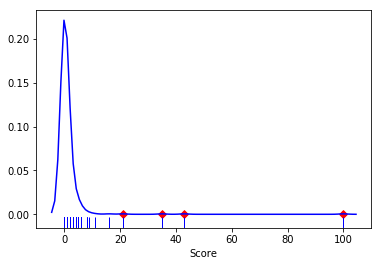

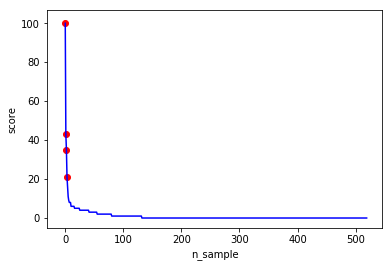

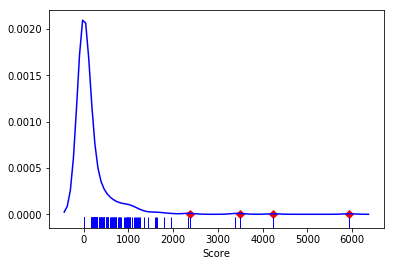

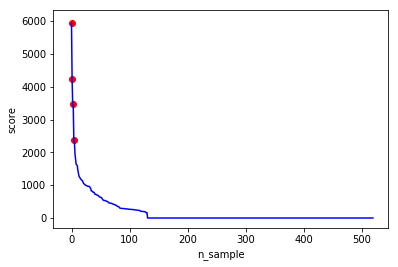

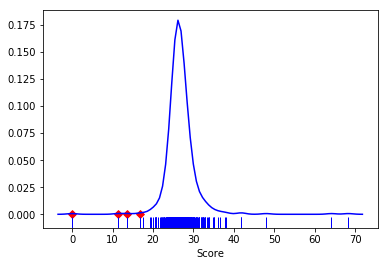

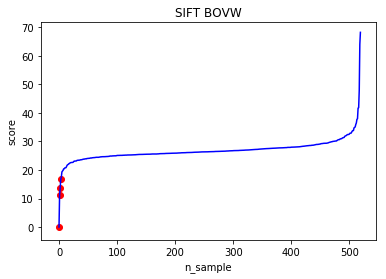

In [249]:
print (q_path)
matches, t = search_SIFT_BF(returnCount=520)
a ,d, ind, cnt = accuracy.accuracy_matches(q_path, matches, ACCURRACY_RANGE)
print (a,d,ind,cnt, '\tTotal returned:', len(matches))
plotDistribution(q_path, matches)
plot_match_scores(imagematches=matches)

matches, t = search_SIFT_BF_DIST(returnCount=520)
plotDistribution(q_path, matches)
plot_match_scores(imagematches=matches)

matches, t = search_SIFT_BOVW(returnCount=520)
plotDistribution(q_path, matches)
plot_match_scores(imagematches=matches, mytitle='SIFT BOVW')

# Tree distance metric 

In [262]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

YD = list(mydataHSV['imagehist'])
YA = np.asarray(YD)
# nsamples, nx, ny, nz = XA.shape  # know the shape before you flatten
# X = XA.reshape ((nsamples, nx*ny*nz)) # gives a 2 D matice (sample, value) which can be fed to KMeans 
tHSVtree = KDTree(YA )

./imagesbooks/ukbench10167.jpg


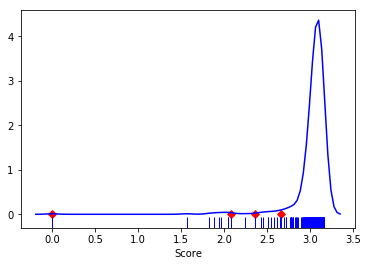

In [263]:
print (q_path)
matches, t = search_HSV(myHSVtree=myHSVtree, returnCount=520)
plotDistribution(q_path, matches)

./imagesbooks/ukbench10167.jpg


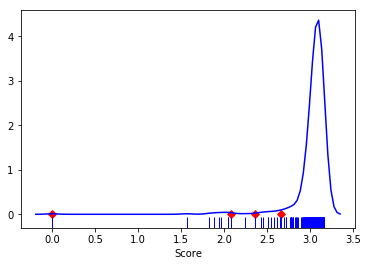

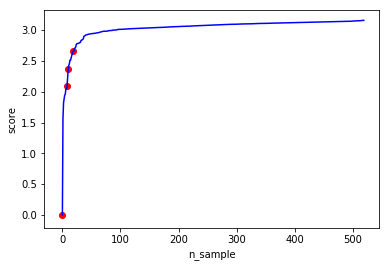

In [264]:
print (q_path)
matches, t = search_HSV(myHSVtree=tHSVtree, returnCount=520)
plotDistribution(q_path, matches)
plot_match_scores(imagematches=matches)

# Start SIFT HERE 

In [67]:
q_path

'./imagesbooks/ukbench06048.jpg'

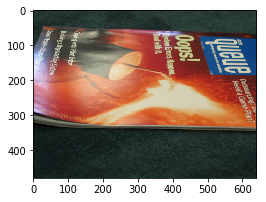

./imagesbooks/ukbench10167.jpg
0.0 563 [0, 66, 104, 175] 4 	Total returned: 520


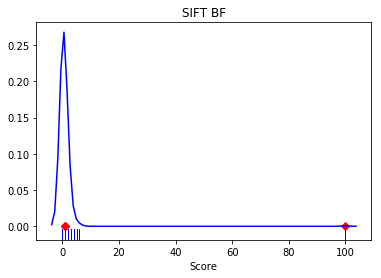

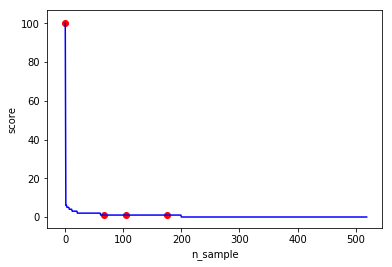

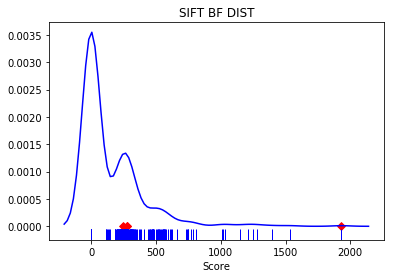

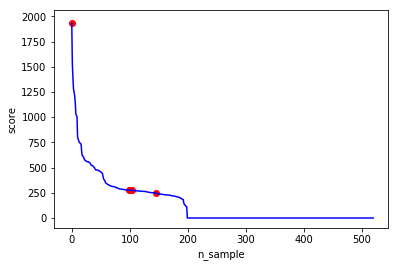

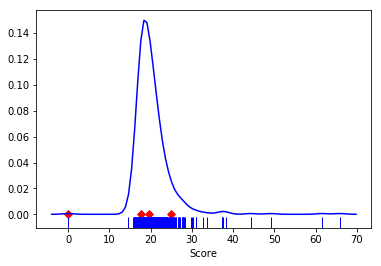

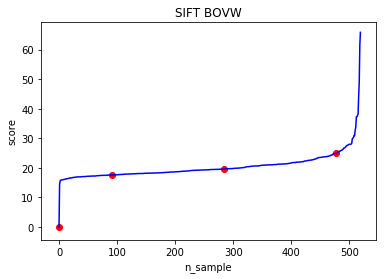

NameError: name 'search_HSV' is not defined

In [253]:
# q_path = './imagesbooks/ukbench05965.jpg'
q_path = './imagesbooks/ukbench10167.jpg'
# q_paths = ''

showImages([q_path])
# showHistograms([q_path])

print (q_path)
matches, t = search_SIFT_BF(returnCount=520)
a ,d, ind, cnt = accuracy.accuracy_matches(q_path, matches, ACCURRACY_RANGE)
print (a,d,ind,cnt, '\tTotal returned:', len(matches))
plotDistribution(q_path, matches, mytitle='SIFT BF')
plot_match_scores(imagematches=matches)

matches, t = search_SIFT_BF_DIST(returnCount=520)
plotDistribution(q_path, matches, mytitle='SIFT BF DIST')
plot_match_scores(imagematches=matches)

matches, t = search_SIFT_BOVW(returnCount=520)
plotDistribution(q_path, matches)
plot_match_scores(imagematches=matches, mytitle='SIFT BOVW')

# get imageatches 
matches1, t = search_HSV(returnCount=520)   # for Corr based search 
plotDistribution(q_path=q_path, imagematches=matches1, mytitle='HSV Tree', myylabel='Prob')
plot_match_scores(imagematches=matches1)


matches2, t = search_RGB(returnCount=520)  # for Tree search 
plotDistribution(q_path=q_path, imagematches=matches2, mytitle='RGB Corr')
plot_match_scores(imagematches=matches2)

In [272]:
# Unzip list of tuples (imagematches) to two separate lists
mScores, mFiles = zip(*matches1)

# Format the scores to 2.2 float (2 precision) numbers
mScoresFormatted = [ ("Bh dist: %2.2f"%score) for score in mScores[:10] ]


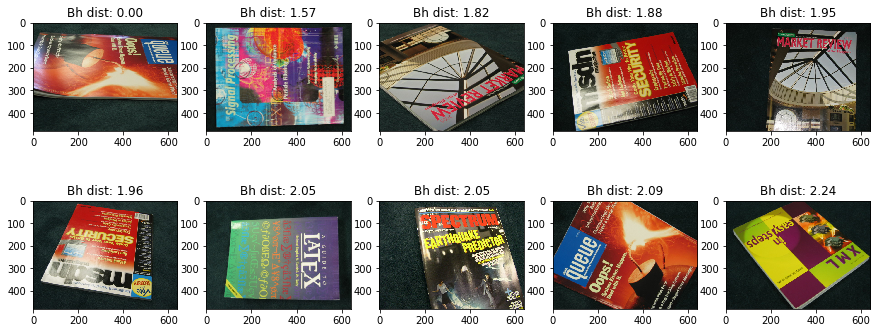

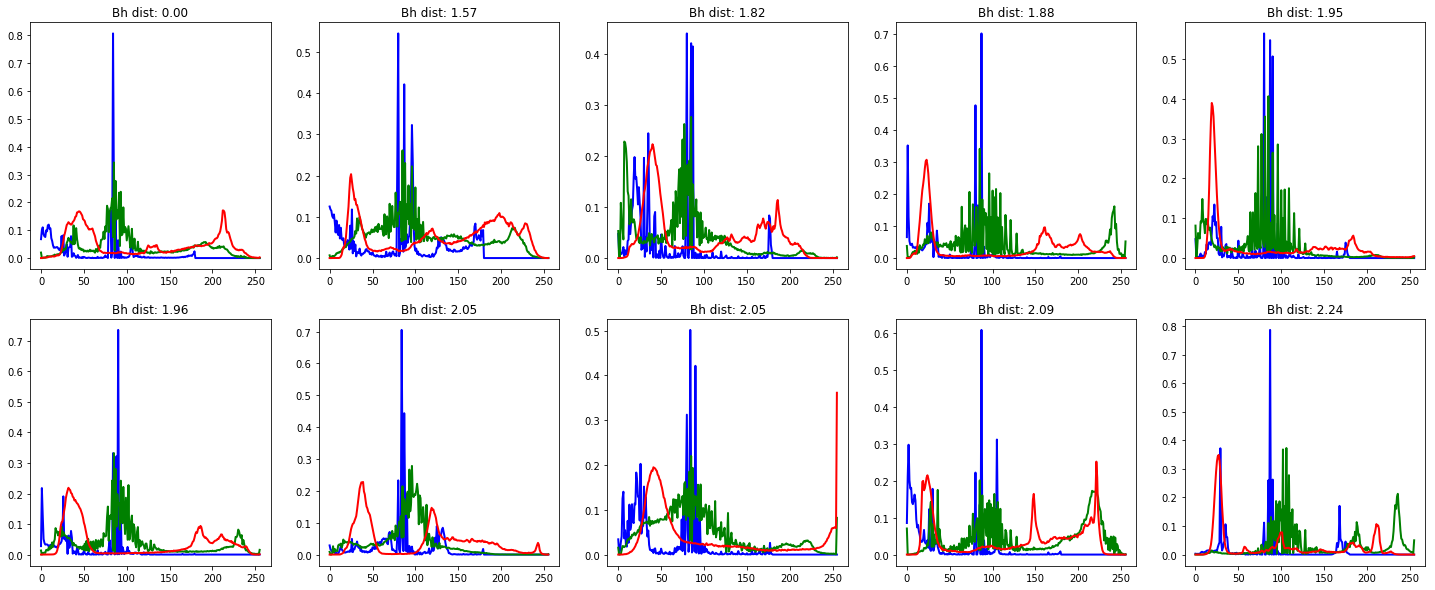

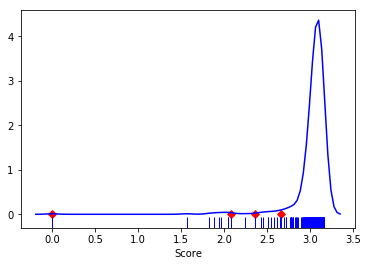

In [277]:
# showImages(mFiles[:10])
showImagesTable(mFiles[:10],columns=7, texts=mScoresFormatted[:10])
showHistogramTable(mFiles[:10], texts=mScoresFormatted[:10])
plotDistribution(q_path=q_path, imagematches=matches1)

Do not use
## Distribution Comparison: HSV tree, RGB Corr, RGB Tree

Query Image ./imagesbooks/ukbench10167.jpg


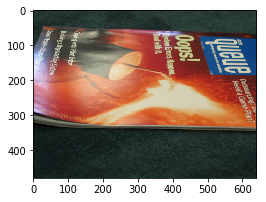

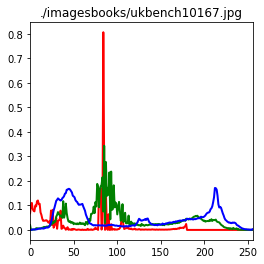

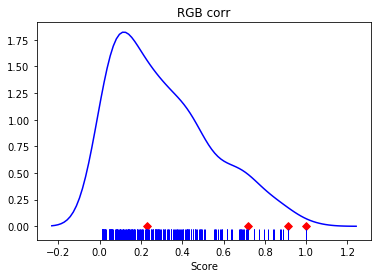

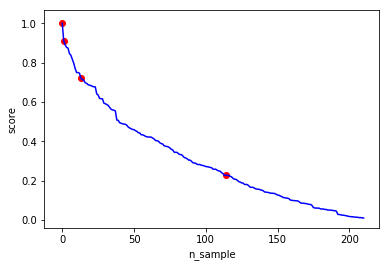

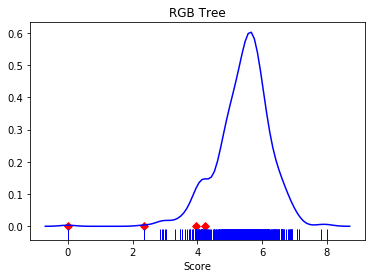

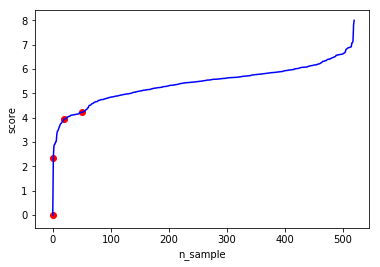

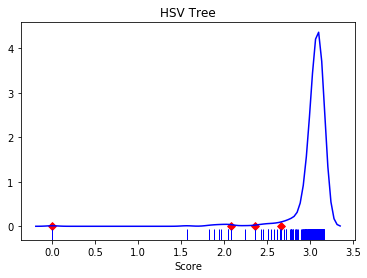

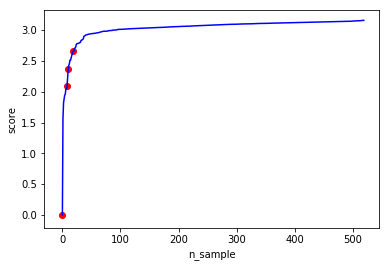

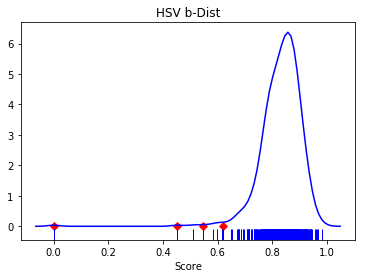

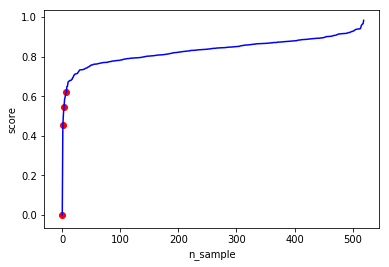

In [313]:
# do not use 
print ('Query Image', q_path)
showImages([q_path])
showHistograms([q_path])
matches, t = search_RGB_Corr(returnCount=520)
plotDistribution(q_path, matches, mytitle='RGB corr')
plot_match_scores(imagematches=matches)
matches, t = search_RGB(returnCount=520)
plotDistribution(q_path, matches, mytitle='RGB Tree')
plot_match_scores(imagematches=matches)
matches, t = search_HSV(returnCount=520)
plotDistribution(q_path, matches, mytitle='HSV Tree')
plot_match_scores(imagematches=matches)
t, matches = getHSVDistScores(q_path)[0]
plotDistribution(q_path, matches, mytitle='HSV b-Dist')
plot_match_scores(imagematches=matches)

# Correlation Matrix 

In [290]:
imagepaths = sorted (imagepaths)
print (len(imagepaths))
# print (imagepaths)

520


In [291]:
# Example: 
q_path = imagepaths[8]
# matches, t = search_RGB_Corr(returnCount=520)
matches, t = search_HSV(returnCount=520)

In [292]:
myrow_dict = dict((y, x) for x, y in matches)
myrow_dict['file'] = q_path
# myrow_dict

# Example pandas df for corr matrix
corrTable = pd.DataFrame ()
corrTable = corrTable.append (myrow_dict,ignore_index=True)
corrTable.set_index('file')

,./imagesbooks/ukbench00000.jpg,./imagesbooks/ukbench00001.jpg,./imagesbooks/ukbench00002.jpg,./imagesbooks/ukbench00003.jpg,./imagesbooks/ukbench00032.jpg,./imagesbooks/ukbench00033.jpg,./imagesbooks/ukbench00034.jpg,./imagesbooks/ukbench00035.jpg,./imagesbooks/ukbench00124.jpg,./imagesbooks/ukbench00125.jpg,...,./imagesbooks/ukbench10158.jpg,./imagesbooks/ukbench10159.jpg,./imagesbooks/ukbench10160.jpg,./imagesbooks/ukbench10161.jpg,./imagesbooks/ukbench10162.jpg,./imagesbooks/ukbench10163.jpg,./imagesbooks/ukbench10164.jpg,./imagesbooks/ukbench10165.jpg,./imagesbooks/ukbench10166.jpg,./imagesbooks/ukbench10167.jpg
file,,,,,,,,,,,,,,,,,,,,,
./imagesbooks/ukbench00124.jpg,2.664165,2.777156,2.605668,2.175134,2.946944,2.335857,2.243744,2.727797,0.0,1.259371,...,3.0614,3.065666,2.918183,3.002697,3.01633,2.973474,2.941135,2.995869,3.046324,3.042216


In [293]:
corrTable = pd.DataFrame (columns=['file'])

for q_path in imagepaths: 
    myrow_dict = {}
    matches, t = search_HSV(returnCount=520)
    myrow_dict = dict((y, x) for x, y in matches)
    myrow_dict['file'] = q_path
    # myrow_dict

    # Example pandas df for corr matrix
    corrTable = corrTable.append (myrow_dict,ignore_index=True)
corrTable = corrTable.set_index('file')

In [303]:
corrTable.shape # note this is a pd dataframe

(520, 520)

In [304]:
corrTable.head()

,./imagesbooks/ukbench00000.jpg,./imagesbooks/ukbench00001.jpg,./imagesbooks/ukbench00002.jpg,./imagesbooks/ukbench00003.jpg,./imagesbooks/ukbench00032.jpg,./imagesbooks/ukbench00033.jpg,./imagesbooks/ukbench00034.jpg,./imagesbooks/ukbench00035.jpg,./imagesbooks/ukbench00124.jpg,./imagesbooks/ukbench00125.jpg,...,./imagesbooks/ukbench10158.jpg,./imagesbooks/ukbench10159.jpg,./imagesbooks/ukbench10160.jpg,./imagesbooks/ukbench10161.jpg,./imagesbooks/ukbench10162.jpg,./imagesbooks/ukbench10163.jpg,./imagesbooks/ukbench10164.jpg,./imagesbooks/ukbench10165.jpg,./imagesbooks/ukbench10166.jpg,./imagesbooks/ukbench10167.jpg
file,,,,,,,,,,,,,,,,,,,,,
./imagesbooks/ukbench00000.jpg,0.000000,1.305388,2.068298,2.141770,2.545681,2.399828,2.380842,2.688262,2.664165,2.663130,...,3.094018,3.125561,2.758471,2.852013,2.988495,2.934943,3.052656,3.103415,3.135447,3.109861
./imagesbooks/ukbench00001.jpg,1.305388,0.000000,1.878692,2.162487,2.709673,2.584836,2.497529,2.727124,2.777156,2.655484,...,3.088477,3.119642,2.893966,2.949311,3.018523,2.992136,3.067364,3.112833,3.128867,3.114837
./imagesbooks/ukbench00002.jpg,2.068298,1.878692,0.000000,2.151258,2.829190,2.368485,2.352479,2.724053,2.605668,2.398975,...,3.079042,3.111496,2.781067,2.896570,3.007167,2.961456,3.075998,3.112913,3.128537,3.121107
./imagesbooks/ukbench00003.jpg,2.141770,2.162487,2.151258,0.000000,2.841850,1.913709,2.062227,2.534837,2.175134,2.176882,...,3.089770,3.105437,2.912234,2.959503,3.026737,3.012804,3.078725,3.094254,3.125199,3.118979
./imagesbooks/ukbench00032.jpg,2.545681,2.709673,2.829190,2.841850,0.000000,2.766460,2.830110,2.714525,2.946944,2.997296,...,3.053499,3.120717,2.819941,2.952002,3.019401,2.993107,3.063354,3.020372,2.913016,3.085511


In [305]:
L = np.asarray (corrTable)

### Selectivity increased 

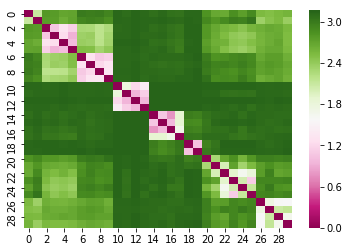

In [306]:
sns.heatmap( L[150:180, 150:180], cmap="PiYG")   # PiYG # BuGn
# sns.heatmap( L[200:230, 200:230], cmap="PiYG")   # PiYG # BuGn

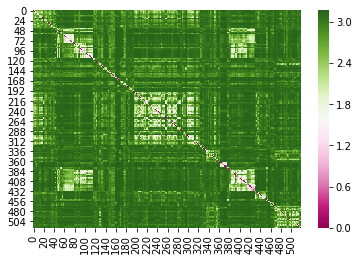

In [307]:
sns.heatmap( L, cmap="PiYG")   # PiYG # BuGn

# Some Testing -- DONOT USE

In [29]:
# visualizing the histogram
def showHistogramsSNS (q_paths): # list of paths 
    for q_path in q_paths:
        img = cv2.imread(q_path)
        color = ('b','g','r')
        plt.figure(figsize=(4,4))
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,256])
            histr = cv2.normalize(histr, None)
            x = histr.reshape(256)
            sns.kdeplot(x, shade=True, color=col)
            
        plt.title(q_path)
        plt.show()

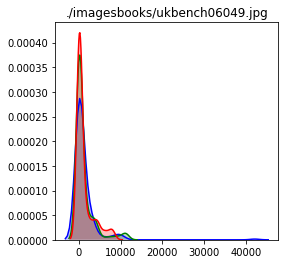

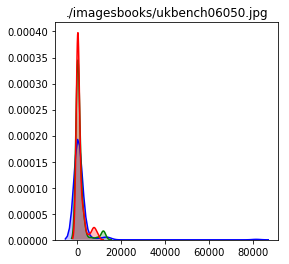

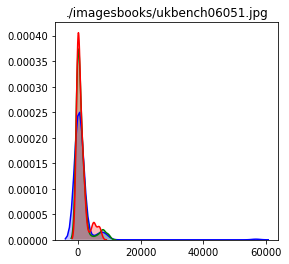

In [30]:
showHistogramsSNS(q_paths[:3])

In [23]:
img = cv2.imread(q_path)
color = ('b','g','r')
plt.figure(figsize=(4,4))
# for i,col in enumerate(color):
histr = cv2.calcHist([img],[0],None,[256],[0,256])
histr = cv2.normalize(histr, None)
# plt.plot(histr,color = col, linewidth=2.0)
# plt.xlim([0,256])

<Figure size 288x288 with 0 Axes>

In [24]:
x = histr.reshape(256)

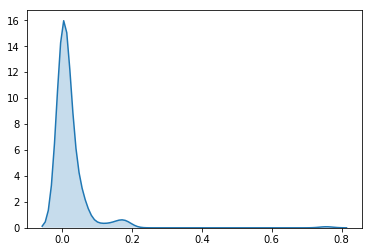

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.kdeplot(x, shade=True)

In [31]:
x

array([7.56106138e-01, 1.59975916e-01, 1.72454387e-01, 1.79474652e-01,
       1.88775167e-01, 1.84609681e-01, 1.77625328e-01, 1.68594137e-01,
       1.59688637e-01, 1.46527886e-01, 1.34103268e-01, 1.23115018e-01,
       1.09702900e-01, 9.84094217e-02, 8.59488994e-02, 7.51581565e-02,
       6.72401562e-02, 5.57850897e-02, 4.82082292e-02, 4.00029570e-02,
       3.47781517e-02, 2.96072140e-02, 2.39874087e-02, 2.11505760e-02,
       1.86189692e-02, 1.69132780e-02, 1.54230427e-02, 1.37353055e-02,
       1.21912062e-02, 1.18141584e-02, 1.10241538e-02, 1.01084663e-02,
       9.12096072e-03, 9.28255264e-03, 7.91799929e-03, 7.77436234e-03,
       6.73299283e-03, 6.44571846e-03, 6.03276165e-03, 5.76344179e-03,
       5.97889768e-03, 5.97889768e-03, 6.60731038e-03, 7.25367758e-03,
       7.12799514e-03, 7.57686142e-03, 8.07959121e-03, 8.61823093e-03,
       8.70800391e-03, 9.24664363e-03, 9.74937342e-03, 1.03957411e-02,
       1.10421088e-02, 1.08984709e-02, 1.15089295e-02, 1.27657549e-02,
      